# Ordinary Differential Equations

In [15]:
import numpy as np
import jax.numpy as jnp
%matplotlib widget
import matplotlib.pyplot as plt


## Dynamics of ideal pendulum

We want to predict how the angle of a pendulum, $u$ changes as a function of time subject to gravity.
The dynamical system can be characterized by two states: 
* u : the position
* du : the velocity

Note that the states of a system do not have to be derivatives of each other, it just happens to be the case for many dynamical systems describing physical phenomena.

Text(0, 0.5, 'ddu')

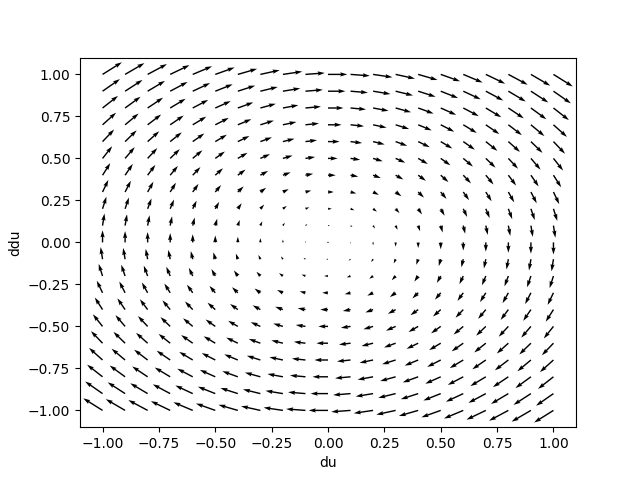

In [16]:
m = 1.0 # mass
g = 1.0 # gravity

x_min = -1.0
x_max = 1.0
y_min = -1.0
y_max = 1.0
dx = 0.1
dy = 0.1

def f(t,y):
    u, du = y
    ddu = -(g/m)*np.sin(u)
    return du, ddu

x, y = np.meshgrid(np.arange(x_min,x_max+dx,dx), np.arange(y_min, y_max+dy,dy))
du,ddu = f(None,(x,y))

#plt.streamplot(x,y,du,ddu)
plt.quiver(x,y,du,ddu, scale_units="xy",angles="xy")
plt.xlabel("du")
plt.ylabel("ddu")

## Obtaining a trajectory

### Implementing Forward Euler

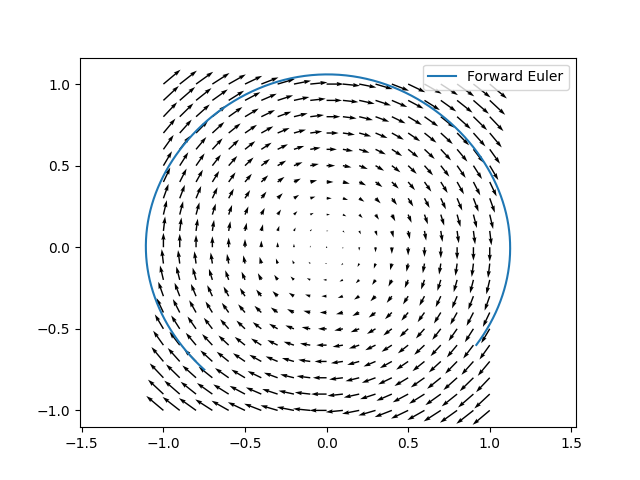

In [17]:
t_start = 0.0
t_end = 5.0
dt = 0.01
t_eval = np.arange(t_start, t_end+dt ,dt)
y0 = (-0.75, -0.75)

def solve_forward_euler(t_start, t_end, dt, y0):
    y0 = np.array(y0)
    t_eval = t_eval = np.arange(t_start, t_end+dt ,dt)
    y = y0
    ys = [y0]
    for t in t_eval[:-1]:
        dy = np.array(f(t,y))
        y = y + dt*dy
        ys.append(y)
    
    return np.stack(ys,axis=1)

u_fe, du_fe = solve_forward_euler(t_start,t_end,dt,y0)
fig, ax = plt.subplots()
ax.quiver(x,y,du,ddu)
ax.plot(u_fe,du_fe, label="Forward Euler")

ax.axis("equal")
plt.legend()

### Using third-party solver

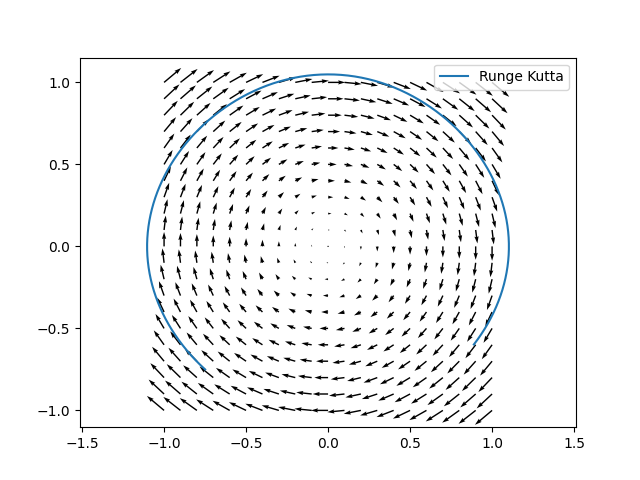

In [18]:
from scipy.integrate import solve_ivp

u_rk45, du_rk45 = solve_ivp(f, (t_start,t_end), y0, "RK45", t_eval).y

fig, ax = plt.subplots()
ax.quiver(x,y,du,ddu)
ax.plot(u_rk45,du_rk45, label="Runge Kutta")
ax.axis("equal")
plt.legend()

## Learning dynamics from data

In [96]:
from jax.experimental.stax import serial, Dense, Softplus
from jax import random
from jax import vmap
import jax.numpy as jnp
from tqdm import tqdm

key = random.PRNGKey(0) # every random operation in jax is seeded

## Partially known dynamics
Suppose we know the shape of the derivative function, but only have rough estimates of the coefficients?

Text(0.5, 0, 'ddu')

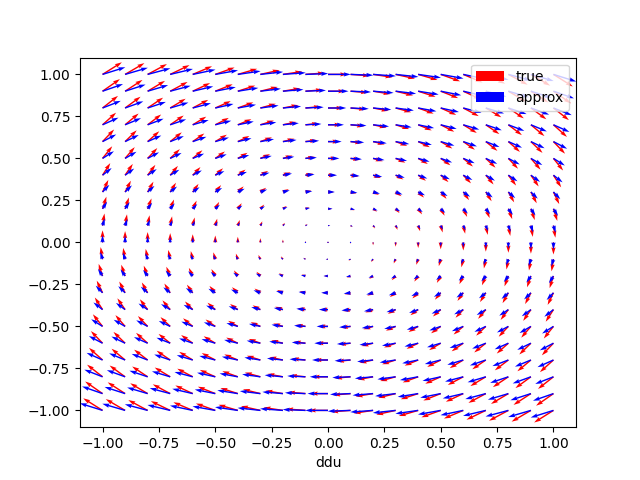

In [83]:
m_true = 1.0
m_approx = 2.0
g = 1.0

def f(u, du, m):
    ddu = - g/m * jnp.sin(u)
    return du, ddu

x, y = np.meshgrid(np.arange(x_min,x_max+dx,dx), np.arange(y_min, y_max+dy,dy))
du_approx, ddu_approx = f(x, y, m_approx)
du_true, ddu_true = f(x, y, m_true)

fig, ax = plt.subplots()
ax.quiver(x,y,du_true,ddu_true, scale_units="xy",angles="xy", label="true", color="red")
ax.quiver(x,y,du_approx,ddu_approx, scale_units="xy",angles="xy", label="approx", color="blue")
ax.legend()
ax.set_xlabel("du")
ax.set_xlabel("ddu")

Is it possible to tune optimize the choice of $\hat{m}$ such that the dynamics of the true system are approximated well?

Two scenarios are:
1. We know ground truth derivatives, $du, ddu$
2. We know ground solutions trajectories $du(t), ddu(t)$ and use these to infer $du, ddu$ that lead to correct trajectories

training: 100%|██████████| 60/60 [00:00<00:00, 312.68it/s]


value of m estimated to 1.0000056028366089, true value is 1.0


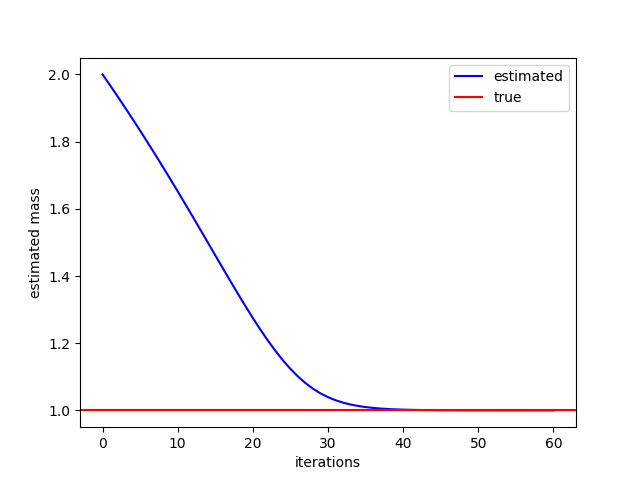

In [97]:
from jax import value_and_grad
from jax import jit

m_approx = 2.0
learning_rate = 0.001

def loss(m):
    du, ddu = f(x,y,m)
    return jnp.sum((du-du_true)**2 + (ddu-ddu_true)**2)

#@jit
def update(m):
    value, grad = value_and_grad(loss, argnums=0)(m)
    m = m - learning_rate * grad
    return m


ms = [m_approx]
for i in tqdm(range(60),desc="training"):
    
    m_approx = update(m_approx)
    ms.append(m_approx)

fig, ax = plt.subplots()
ax.plot(ms,label="estimated",c="blue")
ax.set_xlabel("iterations")
ax.set_ylabel("estimated mass")
ax.axhline(m_true,label="true",c="red")
ax.legend()

print(f"value of m estimated to {m_approx}, true value is {m_true}")


DeviceArray(1.0000001, dtype=float32, weak_type=True)

## Completely unknown dynamics

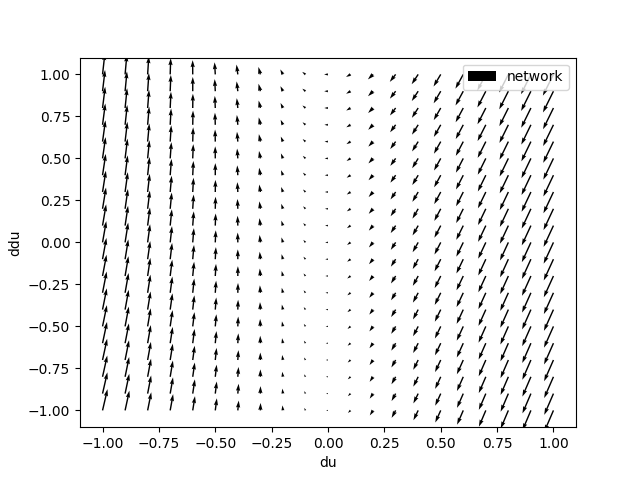

In [52]:
init_net, net = serial(Dense(32),Softplus, Dense(2))

_, params = init_net(key,(2,))

x = jnp.ones((2,))

net(params, x)

def forward_direct(params,u,du):
    x = jnp.asarray((u,du))
    du, duu = net(params,x)
    return du, duu

# for a single scalar input
du, duu = forward_direct(params, 0.0, 0.0)

# for u and du as 2d grid
x,y = jnp.meshgrid(jnp.arange(x_min,x_max+dx, dx),jnp.arange(y_min,y_max+dy, dy))

forward_batched = vmap(forward_direct, (None,0,0),0)
forward_batched = vmap(forward_batched, (None,1,1),1)
du, duu = forward_batched(params,x,y)

fig, ax = plt.subplots()
ax.quiver(x,y,du,ddu, scale_units="xy",angles="xy", label="network")
ax.set_xlabel("du")
ax.set_ylabel("ddu")
ax.legend()